
# Lecture 1 — Part 2: Inverse Kinematics (IK) via Optimization + Simple Constraints

**Goal:** Solve \(\min_q \| f_{FK}(q) - p^* \|^2\) and add simple constraints, without relying on external solvers.

**Key ideas**
- Loss: \(L(q) = \|p(q) - p^*\|^2\)
- Gradient step using Jacobian transpose: \(\Delta q = \alpha J(q)^\top (p^* - p(q))\)
- Simple constraints: joint limits and a ground plane (surface) penalty
- Multiple IK solutions and initialization dependence


### Imports and Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# For Jupyter/Colab inline plots:
# %matplotlib inline

### Forward kinematics (FK) and Jacobian

In [2]:
def fk(theta1, theta2, l1=1.0, l2=1.0):
    """Forward kinematics: q = [theta1, theta2] -> p = [px, py]."""
    px = l1*np.cos(theta1) + l2*np.cos(theta1 + theta2)
    py = l1*np.sin(theta1) + l2*np.sin(theta1 + theta2)
    return np.array([px, py])

def jacobian(theta1, theta2, l1=1.0, l2=1.0):
    """
    Geometric Jacobian J = d p / d q (2x2) for the 2-link planar arm.
    Rows: [dpx/dtheta1, dpx/dtheta2; dpy/dtheta1, dpy/dtheta2]
    """
    s1, c1 = np.sin(theta1), np.cos(theta1)
    s12, c12 = np.sin(theta1+theta2), np.cos(theta1+theta2)
    J = np.array([[-l1*s1 - l2*s12, -l2*s12],
                  [ l1*c1 + l2*c12,  l2*c12]])
    return J


### Constraints helpers (joint limits & ground penalty)

In [3]:
def project_joint_limits(q, limits):
    """
    Project joint angles into box constraints.
    limits: [(min1, max1), (min2, max2)]
    """
    return np.array([np.clip(q[0], limits[0][0], limits[0][1]),
                     np.clip(q[1], limits[1][0], limits[1][1])])

def ground_penalty(p, ground_y=0.0, k=10.0):
    """
    Soft penalty for going below a horizontal surface y=ground_y.
    Returns (penalty_value, grad_wrt_p).
    """
    py = p[1]
    if py >= ground_y:
        return 0.0, np.array([0.0, 0.0])
    r = ground_y - py
    val = (r**2)
    grad_p = np.array([0.0, -2*r])  # d(val)/d(p)
    return k*val, k*grad_p


### IK optimizer (Jacobian-transpose step, with optional constraints)

In [4]:
def ik_optimize(p_star, q0=np.zeros(2), l1=1.0, l2=1.0, steps=300, alpha=0.05,
                joint_limits=None, use_ground=False, ground_y=0.0, ground_k=5.0,
                verbose=False):
    """
    Minimize ||fK(q) - p*||^2 using a simple Jacobian-transpose gradient step.
    Optional: joint limit projection and ground penalty.
    """
    q = q0.copy().astype(float)
    traj = [q.copy()]
    for t in range(steps):
        p = fk(q[0], q[1], l1, l2)
        e = p_star - p               # position error in task space
        J = jacobian(q[0], q[1], l1, l2)

        # Basic gradient step in joint space
        dq = alpha * (J.T @ e)

        # Optional: push EE above ground plane if below it
        if use_ground:
            pen, grad_p = ground_penalty(p, ground_y=ground_y, k=ground_k)
            dq += alpha * (J.T @ grad_p)

        q = q + dq

        # Optional: project to joint limits
        if joint_limits is not None:
            q = project_joint_limits(q, joint_limits)

        traj.append(q.copy())

        if verbose and t % 50 == 0:
            print(f"step {t:03d}: p={p}, err={np.linalg.norm(e):.4f}")

        if np.linalg.norm(e) < 1e-3:  # early stop
            break

    return np.array(q), np.array(traj)


### Plotting Helper

In [5]:
def plot_ik(q_traj, p_star, l1=1.0, l2=1.0, ground_y=None):
    """Plot end-effector path traced by the IK iterations."""
    xs, ys = [], []
    for q in q_traj:
        p = fk(q[0], q[1], l1, l2)
        xs.append(p[0]); ys.append(p[1])

    plt.figure(figsize=(6,6))
    plt.plot(xs, ys, marker='o', linewidth=1, label="EE path")
    plt.scatter([p_star[0]], [p_star[1]], marker='x', label="target")
    if ground_y is not None:
        plt.axhline(ground_y, linestyle='--', label="ground")
    plt.gca().set_aspect('equal')
    plt.grid(True)
    plt.legend()
    plt.title("End-effector path during IK optimization")
    plt.show()


### Try it: basic IK (no constraints)

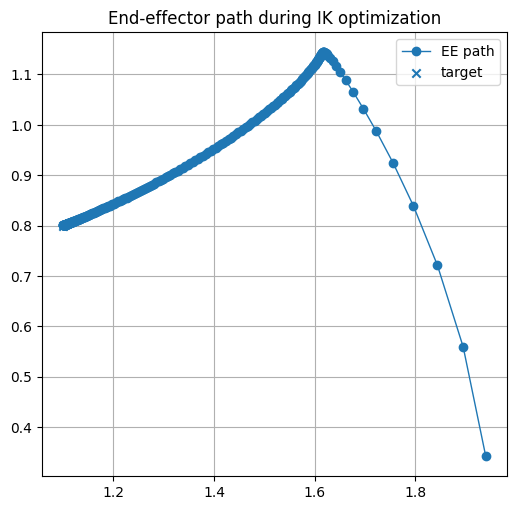

Solution q (deg): [ 83.13256573 -94.23033589]


In [7]:
l1 = l2 = 1.0
p_star = np.array([1.1, 0.8])  # target EE position

q_sol, traj = ik_optimize(
    p_star,
    q0=np.deg2rad([20, -20]),
    l1=l1, l2=l2,
    steps=400,
    alpha=0.08
)

plot_ik(traj, p_star, l1=l1, l2=l2)
print("Solution q (deg):", np.rad2deg(q_sol))



### Add joint limits (e.g., \(\theta_1 \in [0, \pi]\))

This approximates the "surface" constraint from the tutorial (arm cannot swing below the base plane).


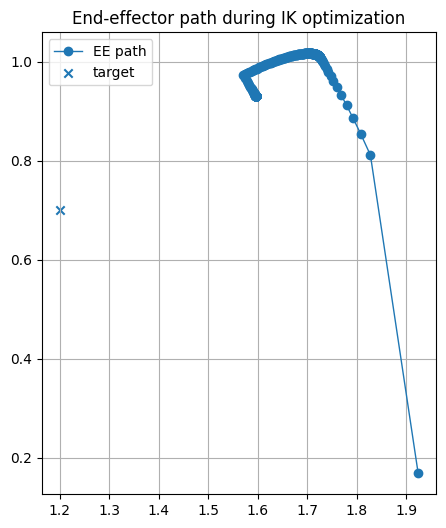

Solution q (deg) with joint limits: [ 7.75643716 45.        ]


In [ ]:

joint_limits = [(0.0, np.pi/4), (0.0, np.pi/4)]
p_star = np.array([1.2, 0.7])
q_sol, traj = ik_optimize(p_star, q0=np.deg2rad([20, -30]), l1=1.0, l2=1.0,
                          steps=500, alpha=0.06, joint_limits=joint_limits)
plot_ik(traj, p_star, l1=1.0, l2=1.0)
print("Solution q (deg) with joint limits:", np.rad2deg(q_sol))



### Add a "ground" (surface) penalty

Soft constraint that repels the end‑effector from going below \(y=0\).


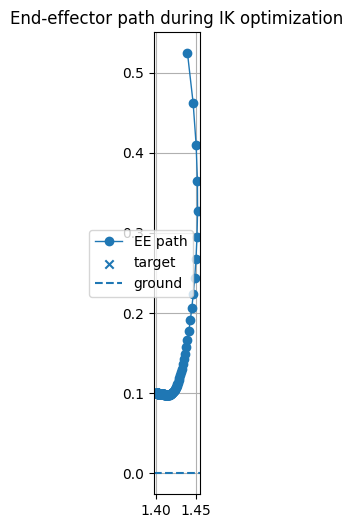

Solution q (deg) with ground penalty: [ 49.46768427 -90.78283119]


In [ ]:

p_star = np.array([1.4, 0.1])
q_sol, traj = ik_optimize(p_star, q0=np.deg2rad([60, -80]), l1=1.0, l2=1.0,
                          steps=600, alpha=0.05,
                          joint_limits=[(0.0, np.pi), (-np.pi, np.pi)],
                          use_ground=True, ground_y=0.0, ground_k=5.0)
plot_ik(traj, p_star, l1=1.0, l2=1.0, ground_y=0.0)
print("Solution q (deg) with ground penalty:", np.rad2deg(q_sol))



**Notes:**  
- Multiple IK solutions exist (elbow‑up vs elbow‑down). Initialization influences which solution you reach.  
- Obstacles can be added as penalties on the arm links (exercise: add a circular obstacle and penalize link collisions).
